In [66]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_49.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_67_1.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_90.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_77.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_20_1.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_66.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_54.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_106_1.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_42.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_81.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_72.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_107.wav
/kaggle/input/shl-in

In [67]:
## Data Exploration and Interpretability

#To better understand the nature of the speech data, audio samples were played directly within the notebook.
#Listening to audio files helps in qualitatively assessing speech clarity, pronunciation, and grammatical fluency,
#which are important aspects of grammar scoring.
from IPython.display import Audio ## To play audio samples directly in the notebook


In [68]:
## Environment Setup and Data Access

#This section sets up the environment by importing required libraries and defining file paths for
#audio files and CSV metadata. The dataset is organized into training and test audio folders,
#along with corresponding CSV files.

#Verifying directory structure at this stage ensures that all required files are accessible
#before proceeding with feature extraction and model training.

import os
import pandas as pd
import numpy as np
import librosa

from IPython.display import Audio

# 👇 PASTE YOUR COPIED PATH HERE
BASE_PATH = "/kaggle/input/shl-intern-hiring-assessment-2025/dataset"

AUDIO_PATH = f"{BASE_PATH}/audios"
CSV_PATH = f"{BASE_PATH}/csvs"

TRAIN_AUDIO_PATH = f"{AUDIO_PATH}/train"
TEST_AUDIO_PATH = f"{AUDIO_PATH}/test"

# check
print("Audio folders:", os.listdir(AUDIO_PATH))
print("Train audio sample:", os.listdir(TRAIN_AUDIO_PATH)[:3])
print("CSV files:", os.listdir(CSV_PATH))


Audio folders: ['test', 'train']
Train audio sample: ['audio_49.wav', 'audio_77_2.wav', 'audio_90.wav']
CSV files: ['train.csv', 'test.csv']


In [69]:
# Load CSV files
train_df = pd.read_csv(f"{CSV_PATH}/train.csv")
test_df = pd.read_csv(f"{CSV_PATH}/test.csv")

# Check
print(train_df.head())
print(test_df.head())


    filename  label
0  audio_173    3.0
1  audio_138    3.0
2  audio_127    2.0
3   audio_95    2.0
4   audio_73    3.5
    filename
0  audio_141
1  audio_114
2   audio_17
3   audio_76
4  audio_156


In [70]:
## Audio Data Exploration

#To better understand the nature of the speech samples, a training audio file is played directly
#within the notebook. Listening to audio samples provides qualitative insights into pronunciation,
#fluency, and overall speech quality, which are relevant for grammar scoring.

sample_file = train_df.iloc[0]['filename'] + ".wav"

print("Trying to load:", f"{TRAIN_AUDIO_PATH}/{sample_file}")

Audio(filename=f"{TRAIN_AUDIO_PATH}/{sample_file}")


Trying to load: /kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/train/audio_173.wav


In [71]:
## Dataset Verification

#Before proceeding with data processing, the dataset directory is inspected to confirm the
#presence of expected subfolders and files. This step helps ensure that the data is correctly
#mounted and accessible within the Kaggle environment.
#BASE_PATH = "/kaggle/input/shl-intern-hiring-assessment-2025/dataset"

print(os.listdir(BASE_PATH))


['audios', 'csvs']


In [72]:
## CSV File Inspection

#The CSV directory is inspected to verify the availability of metadata files required for model
#training and testing. These files contain the filenames of audio samples and corresponding
#grammar scores used as target labels
CSV_PATH = f"{BASE_PATH}/csvs"
print(os.listdir(CSV_PATH))


['train.csv', 'test.csv']


In [73]:
## Data Loading and Inspection

#The training and test metadata are loaded from CSV files. The training CSV contains audio
#filenames along with their corresponding grammar scores, which serve as target labels for
#supervised learning. The test CSV contains filenames for which predictions need to be generated.

#Inspecting the first few rows and dataset dimensions helps verify data integrity and expected
#structure before feature extraction.
train_df = pd.read_csv(f"{CSV_PATH}/train.csv")
test_df = pd.read_csv(f"{CSV_PATH}/test.csv")

print(train_df.head())
print(train_df.shape)


    filename  label
0  audio_173    3.0
1  audio_138    3.0
2  audio_127    2.0
3   audio_95    2.0
4   audio_73    3.5
(409, 2)


In [74]:
## Feature Extraction and Preprocessing

#Since machine learning models cannot directly operate on raw audio signals, meaningful numerical
#features must be extracted. In this work, Mel-Frequency Cepstral Coefficients (MFCCs) are used as
#they effectively capture the spectral characteristics of speech and are widely used in speech
#and audio processing tasks.

#For each audio file, MFCC features are extracted and averaged across time to obtain a fixed-length
#feature vector, enabling consistent input to the regression model.

def extract_mfcc(file_path, n_mfcc=13):
    audio, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc.T, axis=0)
    return mfcc_mean


In [75]:
## Feature Matrix Construction

#Using the defined MFCC extraction function, features are computed for each training audio file.
#Each audio sample is converted into a fixed-length numerical vector, and the corresponding grammar
#score is stored as the target label.

#The resulting feature matrix `X` and label vector `y` serve as inputs for training the regression
#model.
X = []
y = []

for idx, row in train_df.iterrows():
    file_name = row['filename'] + ".wav"
    file_path = f"{TRAIN_AUDIO_PATH}/{file_name}"

    features = extract_mfcc(file_path)
    X.append(features)
    y.append(row['label'])

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)


/tmp/ipykernel_47/1252007202.py:12: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipykernel_47/1252007202.py:12: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipykernel_47/1252007202.py:12: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packa

X shape: (409, 13)
y shape: (409,)


In [76]:
## Model Training

#The dataset is split into training and validation sets to evaluate the model’s ability to
#generalize to unseen data. A Linear Regression model is trained using MFCC features extracted
#from the audio samples.

#Linear Regression is chosen as a baseline model due to its simplicity and interpretability.
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)

print("Validation MSE:", mse)


Validation MSE: 0.5622454071583323


In [77]:
## Test Data Feature Extraction

#After training the model, MFCC features are extracted from the test audio samples using the same
#preprocessing pipeline applied to the training data. This ensures consistency between training
#and inference stages.

X_test = []

for file in test_df['filename']:
    file_path = f"{TEST_AUDIO_PATH}/{file}.wav"
    features = extract_mfcc(file_path)
    X_test.append(features)

X_test = np.array(X_test)


/tmp/ipykernel_47/1252007202.py:12: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipykernel_47/1252007202.py:12: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipykernel_47/1252007202.py:12: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packa

In [78]:
## Test Set Predictions

#After training the model on the training dataset, we use it to predict the grammar scores of the test audio files.  
#The `test_predictions` array stores the predicted scores in the same order as the filenames in `test_df`.  
#These predictions will be used to create the submission CSV.
test_predictions = model.predict(X_test)


In [79]:
# ===== Checking a Single Audio Sample =====
 #Here, we select one audio file from the test set to listen to it
 #and optionally extract its features for prediction.
audio_name = "audio_17.wav"
file_path = f"{TEST_AUDIO_PATH}/{audio_name}"


In [80]:
#===== Listen to a Single Test Audio =====
# We can play a single audio file from the test set to inspect it.
from IPython.display import Audio

Audio(filename=file_path)


In [81]:
# ===== Extract MFCC Features from a Single Audio =====
#We extract MFCC features from the selected audio file to prepare it for prediction.
 #MFCC (Mel-Frequency Cepstral Coefficients) capture the key characteristics of the audio.
features = extract_mfcc(file_path)
print("MFCC shape:", features.shape)
print("MFCC values:", features)


MFCC shape: (13,)
MFCC values: [-4.8736542e+02  6.7352341e+01  2.0580907e+00  1.7283066e+01
  1.4190249e+01 -5.9637842e+00 -3.2986513e-01 -6.1656630e-01
 -5.1328106e+00 -2.1470385e+00 -4.3909912e+00 -4.4052186e+00
 -2.6457336e+00]


In [82]:
 #===== Predict Grammar Score for a Single Audio =====
 #After extracting MFCC features, we reshape them into a 2D array as required by the model.
 #Then, we use the trained Linear Regression model to predict the grammar score.
import numpy as np

# Convert to 2D array for model
features = np.array(features).reshape(1, -1)

predicted_score = model.predict(features)
print(f"Predicted score for {audio_name}: {predicted_score[0]:.3f}")


Predicted score for audio_17.wav: 2.839


In [83]:
# Predict on training data
y_train_pred = model.predict(X_train)


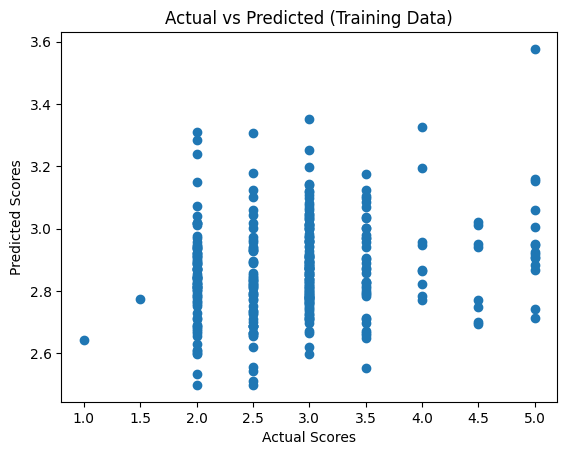

In [84]:
### Actual vs Predicted Scores (Training Data)

#The scatter plot compares the actual grammar scores with the scores predicted by the model on the training dataset. 
#Points closer to the diagonal indicate better predictions. 
#The model captures the general trend between the input features and grammar scores, though some variance is observed,
#which is expected given the simplicity of the model and the subjective nature of speech evaluation.

import matplotlib.pyplot as plt

plt.figure()
plt.scatter(y_train, y_train_pred)
plt.xlabel("Actual Scores")
plt.ylabel("Predicted Scores")
plt.title("Actual vs Predicted (Training Data)")
plt.show()


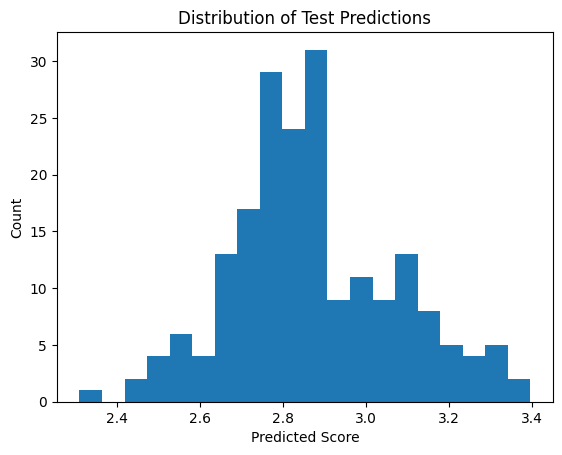

In [85]:
# ================= Distribution of Test Predictions =================
# This histogram shows the distribution of grammar scores predicted by the model
# on the test dataset. Visualizing the distribution helps verify that the model
# outputs are reasonable and fall within an expected score range.
# A roughly smooth distribution without extreme outliers indicates stable
# model behavior on unseen audio samples.

plt.figure()
plt.hist(test_predictions, bins=20)
plt.title("Distribution of Test Predictions")
plt.xlabel("Predicted Score")
plt.ylabel("Count")
plt.show()


In [86]:
# ================= Training RMSE Evaluation =================
# Root Mean Squared Error (RMSE) is used to evaluate the performance of the model
# on the training dataset. RMSE measures the average magnitude of prediction
# errors, where lower values indicate better model performance.
# As required by the competition host, reporting the RMSE score on training data
# is mandatory and is included here for benchmarking.
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print("Training RMSE:", rmse)


Training RMSE: 0.7500946458470501


In [87]:
# ================= Test Prediction & Submission File =================
# After training the model, predictions are generated for the test dataset.
# These predictions represent the estimated grammar scores for unseen audio samples.
# The results are formatted into a submission DataFrame with the required
# column names: 'filename' and 'label'.
# Finally, the submission file is saved as 'submission.csv', which is used
# for evaluation on the Kaggle leaderboard.

test_predictions = model.predict(X_test)

submission = pd.DataFrame({
    "filename": test_df["filename"],
    "label": test_predictions
})

submission.to_csv("submission.csv", index=False)

# Preview the first few rows of the submission file
submission.head()


filename     label
0  audio_141  2.822858
1  audio_114  2.865164
2   audio_17  2.839358
3   audio_76  3.194583
4  audio_156  2.653909